**Introduction**

This will be a short exploratory analysis with the goal of becoming more familiar with the 2018 Data Science Bowl dataset and identifying some possible hurdles that could have a negative effect on model performance.

**Contents:**
- Importing and processing image data
- Looking at the image metadata summary statistics
- Plotting image width, height and area distributions
- Plotting number of nuclei per image distribution
- Plotting images with the most and fewest nuclei
- Plotting the smallest and largest nuclei
- Plotting a sample of images
- Conclusion

In [2]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import utils

TRAIN_PATH = '../../input/stage1_train/'
TEST_PATH = '../../input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [5]:
# sys.stdout.flush()
# These lists will be used to store the images
imgs = []
masks = []

# These lists will be used to store the image metadata that will then be used to create
# pandas dataframes
img_data = []
mask_data = []
print('Processing images ... ')

# Loop over the training images. tqdm is used to display progress as reading
# all the images can take about 1 - 2 minutes
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')
    
    # Get image 
    imgs.append(img)
    img_height = img.shape[0]
    img_width = img.shape[1]
    img_area = img_width * img_height

    # Initialize counter. There is one mask for each annotated nucleus.
    nucleus_count = 1
    
    # Loop over the mask ids, read the images and gather metadata from them
    sz = []
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask = imread(path + '/masks/' + mask_file)
        masks.append(mask)
        mask_height = mask.shape[0]
        mask_width = mask.shape[1]
        mask_area = mask_width * img_height
        
        # Sum and divide by 255 to get the number
        # of pixels for the nucleus. Masks are grayscale
        nucleus_area = (np.sum(mask) / 255)
        sz.append(nucleus_area)
        mask_to_img_ratio = nucleus_area / mask_area
        
        # Append to masks data list that will be used to create a pandas dataframe
        mask_data.append([n, mask_height, mask_width, mask_area, nucleus_area, mask_to_img_ratio])
        
        # Increment nucleus count
        nucleus_count = nucleus_count + 1
    
    # Build image info list that will be used to create dataframe. This is done after the masks loop
    # because we want to store the number of nuclei per image in the img_data list.
    img_data.append([img_height, img_width, img_area, nucleus_count, np.mean(sz), np.min(sz)/np.mean(sz), 
                    np.std(sz)/np.mean(sz), np.max(sz)/np.mean(sz)])

  0%|          | 1/670 [00:00<01:29,  7.46it/s]

Processing images ... 


100%|██████████| 670/670 [03:13<00:00,  3.47it/s]


**Create Images Metadata Dataframe**

Create a pandas data frame from the list of image metadata that was created in the loop above. This will make the data easier to manipulate and plot.

After creating the data frame we can take a look at its summary stats along with the first five and last five rows to make sure it looks ok and get familiar with it.

In [6]:
# Create dataframe for images
df_img = pd.DataFrame(img_data, columns=['height', 'width', 'area', 'nuclei', 'mean_sz', 'min_sz', 'std_sz','max_sz'])

In [7]:
df_img.describe()

,height,width,area,nuclei,mean_sz,min_sz,std_sz,max_sz
count,670.000000,670.000000,6.700000e+02,670.000000,670.000000,670.000000,670.000000,670.000000
mean,333.991045,378.500000,1.547583e+05,44.971642,560.483462,0.195279,0.511137,2.258560
std,149.474845,204.838693,1.908250e+05,47.962530,634.752932,0.178728,0.175894,0.769281
min,256.000000,256.000000,6.553600e+04,2.000000,26.000000,0.011769,0.000000,1.000000
25%,256.000000,256.000000,6.553600e+04,16.250000,150.521825,0.067876,0.389552,1.811783
50%,256.000000,320.000000,8.192000e+04,28.000000,265.434343,0.144237,0.492355,2.116060
75%,360.000000,360.000000,1.296000e+05,55.000000,674.434370,0.265007,0.613563,2.501309
max,1040.000000,1388.000000,1.443520e+06,376.000000,7244.071429,1.000000,1.370426,10.479228


In [8]:
df_img.head()

,height,width,area,nuclei,mean_sz,min_sz,std_sz,max_sz
0,256,256,65536,28,211.666667,0.099213,0.625014,2.173228
1,256,256,65536,37,131.583333,0.265991,0.286467,2.097530
2,256,320,81920,71,419.642857,0.133447,0.495967,2.542638
3,256,320,81920,87,168.906977,0.130249,0.899378,4.452155
4,256,320,81920,8,813.571429,0.186831,0.494558,1.921159


In [9]:
df_img.tail()

,height,width,area,nuclei,mean_sz,min_sz,std_sz,max_sz
665,256,256,65536,14,134.384615,0.468804,0.413652,1.748712
666,256,256,65536,39,68.578947,0.335380,0.409474,2.595549
667,520,696,361920,20,1681.368421,0.040443,0.345391,1.433356
668,256,256,65536,14,152.615385,0.170363,0.512654,2.273690
669,360,360,129600,25,1666.916667,0.035995,0.565760,1.785332


In [10]:
df_img.groupby(['width']).mean()

,height,area,nuclei,mean_sz,min_sz,std_sz,max_sz
width,,,,,,,
256,256.0,65536.0,29.556886,173.749121,0.281873,0.453818,2.086902
320,256.0,81920.0,42.803571,602.698091,0.140715,0.641455,2.813403
347,260.0,90220.0,82.600000,142.241824,0.304408,0.502244,2.478845
360,360.0,129600.0,24.450549,1563.518257,0.042625,0.634252,2.279352
640,512.0,327680.0,32.615385,1243.527609,0.168554,0.566683,2.406583
696,520.0,361920.0,104.826087,855.558787,0.105741,0.395623,2.034478
1024,1024.0,1048576.0,85.062500,242.483783,0.117836,0.742564,2.856277
1272,603.0,767016.0,230.500000,166.179465,0.187116,0.490039,2.602006
1388,1040.0,1443520.0,15.000000,7244.071429,0.602838,0.230438,1.523591


**Create Image Masks Metadata Dataframe**

Let's create another data frame for the masks metadata.

In [14]:
# Create dataframe for masks
df_mask = pd.DataFrame(mask_data, columns=['img_index', 'height', 'width', 'area', 'nucleus_area', 'mask_to_img_ratio'])

In [15]:
df_mask.describe()

,img_index,height,width,area,nucleus_area,mask_to_img_ratio
count,29461.000000,29461.000000,29461.000000,2.946100e+04,29461.000000,29461.000000
mean,328.021724,404.408642,506.068090,2.511955e+05,471.803707,0.003165
std,192.007063,187.400013,282.185678,2.516759e+05,583.837040,0.004488
min,0.000000,256.000000,256.000000,6.553600e+04,21.000000,0.000020
25%,168.000000,256.000000,256.000000,6.553600e+04,118.000000,0.000992
50%,319.000000,360.000000,360.000000,1.296000e+05,305.000000,0.001724
75%,497.000000,520.000000,696.000000,3.619200e+05,574.000000,0.003376
max,669.000000,1040.000000,1388.000000,1.443520e+06,11037.000000,0.083557


In [16]:
df_mask.head()

,img_index,height,width,area,nucleus_area,mask_to_img_ratio
0,0,256,256,65536,259.0,0.003952
1,0,256,256,65536,112.0,0.001709
2,0,256,256,65536,353.0,0.005386
3,0,256,256,65536,174.0,0.002655
4,0,256,256,65536,198.0,0.003021


In [17]:
df_mask.tail()

,img_index,height,width,area,nucleus_area,mask_to_img_ratio
29456,669,360,360,129600,1087.0,0.008387
29457,669,360,360,129600,1863.0,0.014375
29458,669,360,360,129600,957.0,0.007384
29459,669,360,360,129600,2456.0,0.018951
29460,669,360,360,129600,2702.0,0.020849


**Plot some of the metadata distributions**

/Users/stefan/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


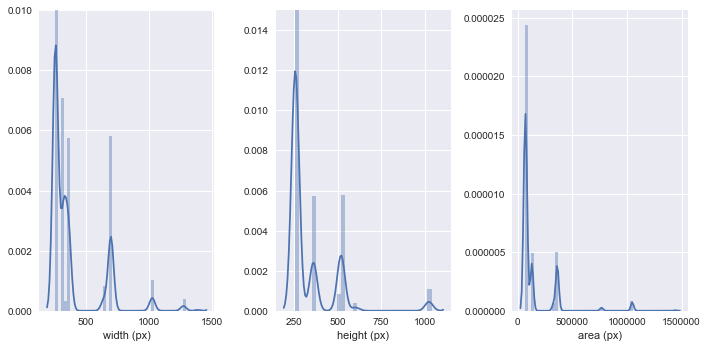

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(10,5))
width_plt = sns.distplot(df_img['width'].values, ax=ax[0])
width_plt.set(xlabel='width (px)')
width_plt.set(ylim=(0, 0.01))
height_plt = sns.distplot(df_img['height'].values, ax=ax[1])
height_plt.set(xlabel='height (px)')
height_plt.set(ylim=(0, 0.015))
area_plt = sns.distplot(df_img['area'].values)
area_plt.set(xlabel="area (px)")
fig.show()
plt.tight_layout()

The image dimensions do not appear to be equally distributed and have a somewhat bimodal distribution. This issue will need to be addressed before feeding the images to our model. The images could be resized to squares but this will cause images to be squashed either vertically or horizontally and would result in a loss of information. Most of the images look like they are 256x256 so the squashing/stretching might not be an issue. Scaling the smaller images up might be a better option than scaling the larger images down as this would also result in a loss of information. Different strategies should be tried here to see what works best. 

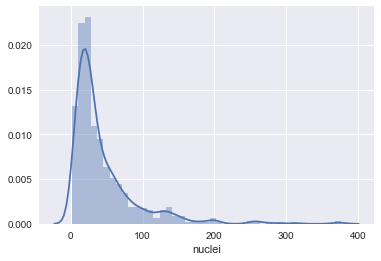

In [19]:
sns.distplot(df_img['nuclei'].values)
plt.xlabel("nuclei")
plt.show()

The distribution of nuclei (masks) per image appears to be skewed to the right. There is quite a large range in the number of nuclei per image. 

421


/Users/stefan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  


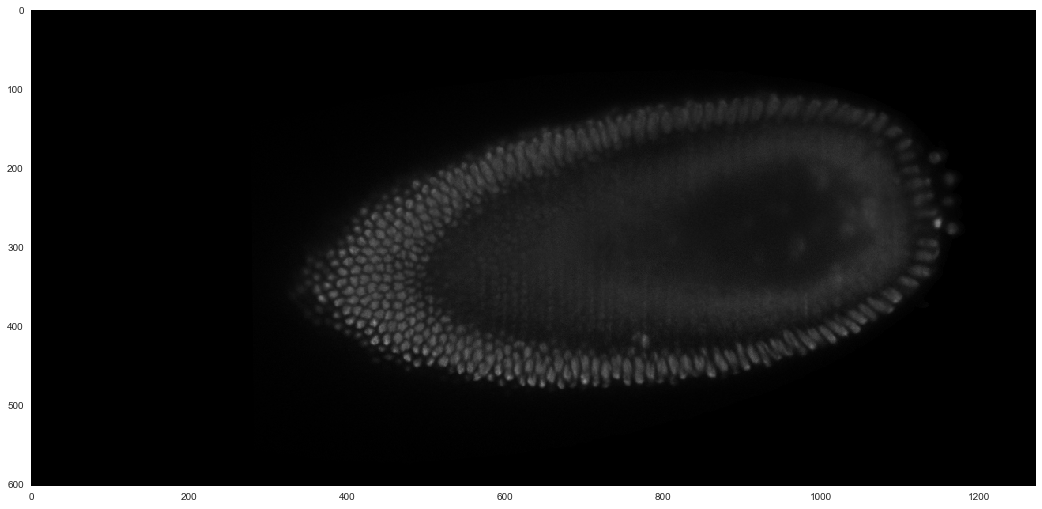

In [20]:
plt.figure(figsize=(18, 18))
much_nuclei = df_img['nuclei'].argmax()
print(much_nuclei)
plt.grid(None)
plt.imshow(imgs[much_nuclei])

There are 198 annotated nuclei in this image. It's an interesting structure, possibly some kind of creature!

2


/Users/stefan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  


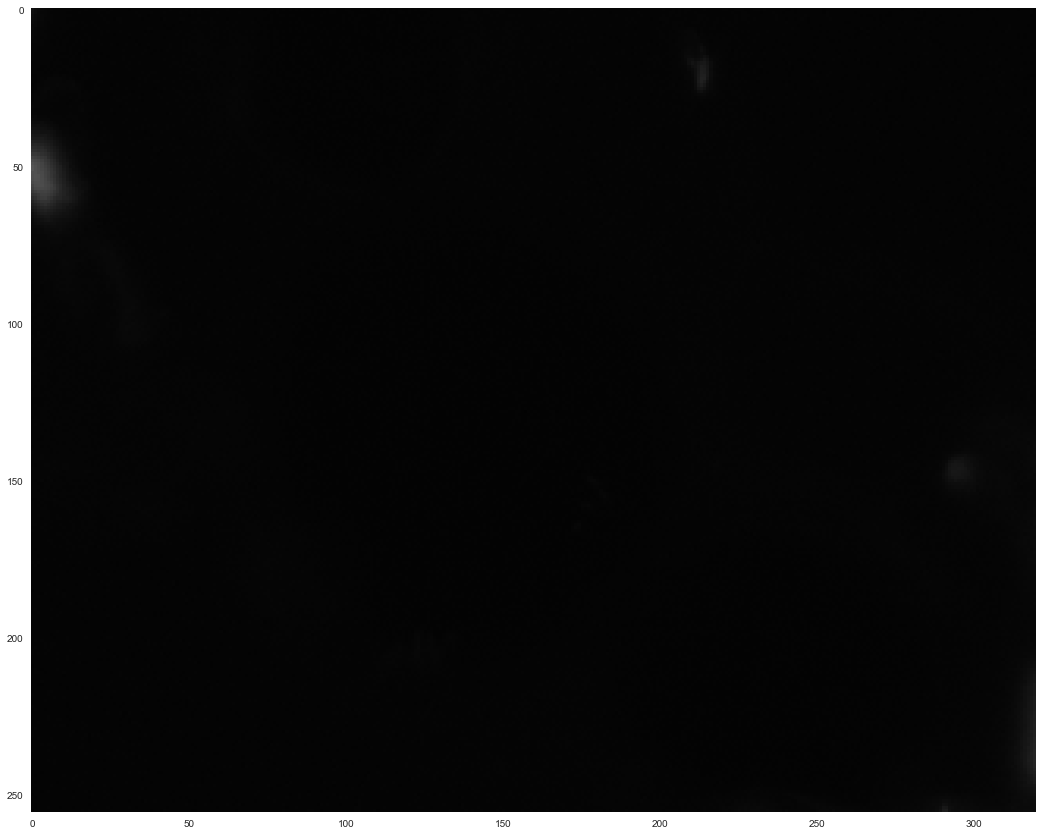

In [21]:
plt.figure(figsize=(18, 18))
not_much_nuclei = df_img['nuclei'].argmin()
print(df_img['nuclei'].min())
plt.grid(None)
plt.imshow(imgs[not_much_nuclei])

There appears to be a lot going on in this image but there are only two annotated nuclei.

**Nuclei Sizes**

Let's take a look at some differently sized nuclei in the training set. 

/Users/stefan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  """Entry point for launching an IPython kernel.


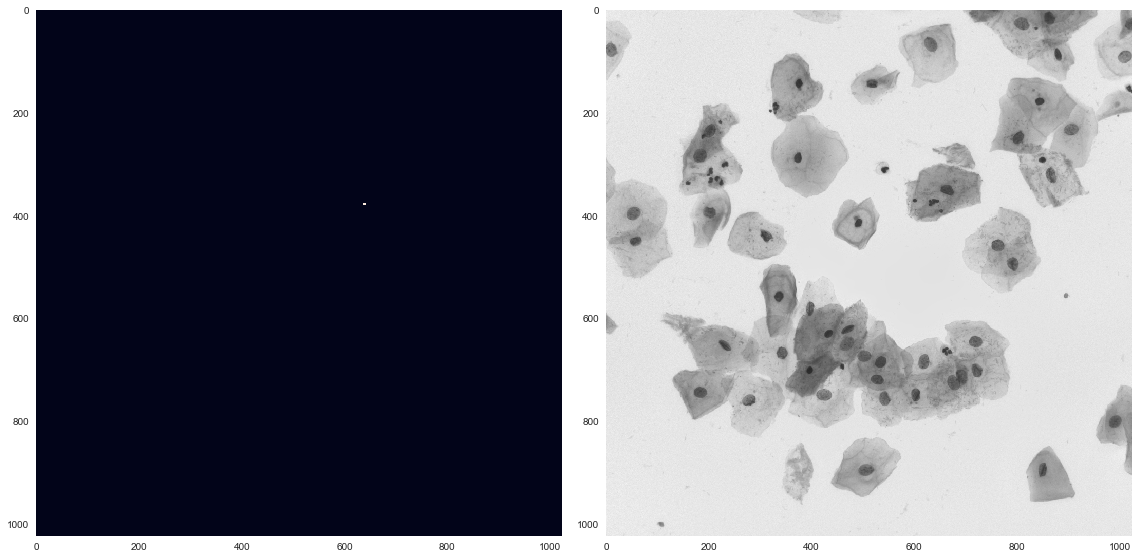

In [22]:
smallest_mask_index = df_mask['mask_to_img_ratio'].argmin()

fig, ax = plt.subplots(1, 2, figsize=(16, 16))
ax[0].grid(None)
ax[0].imshow(masks[smallest_mask_index])
ax[1].grid(None)
ax[1].imshow(imgs[df_mask.iloc[[smallest_mask_index], [0]].values[0][0]])
plt.tight_layout()

Wow! This nucleus is either very small or very far away! This makes me concerned about scaling down some of the larger images as some of these small nuclei could become undetectable or a least much more difficult to detect.

0.0
1.5
5.249999999999972


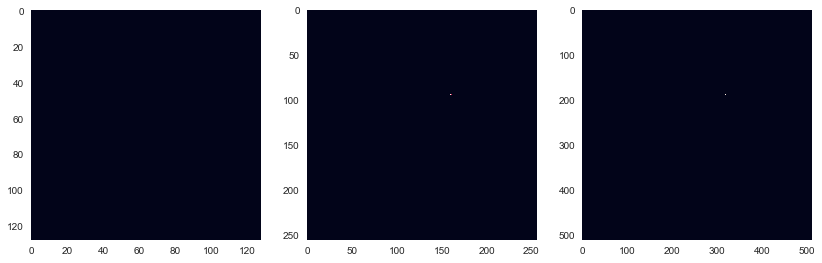

In [23]:
smallest_mask_resized_128 = resize(masks[smallest_mask_index], (128, 128))
smallest_mask_resized_256 = resize(masks[smallest_mask_index], (256, 256))
smallest_mask_resized_512 = resize(masks[smallest_mask_index], (512, 512))
print(np.sum(smallest_mask_resized_128))
print(np.sum(smallest_mask_resized_256))
print(np.sum(smallest_mask_resized_512))
fig, ax = plt.subplots(1, 3, figsize=(14, 14))
ax[0].grid(None)
ax[1].grid(None)
ax[2].grid(None)
ax[0].imshow(smallest_mask_resized_128)
ax[1].imshow(smallest_mask_resized_256)
ax[2].imshow(smallest_mask_resized_512)

As you can see above, the nucleus mask completely disappears when the image is scaled down to 128x128 pixels.

/Users/stefan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  """Entry point for launching an IPython kernel.


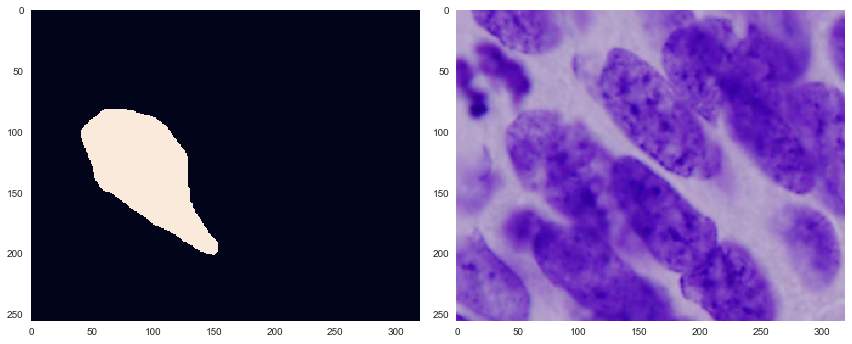

In [24]:
biggest_mask_index = df_mask['mask_to_img_ratio'].argmax()
biggest_mask_img_index = df_mask.iloc[[biggest_mask_index], [0]].values[0][0]

fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].grid(None)
ax[1].grid(None)
ax[0].imshow(masks[biggest_mask_index])
ax[1].imshow(imgs[biggest_mask_img_index])
plt.tight_layout()

In the image on the right, the nuclei appear to overlap each other. Let's see what the masks look like when stacked on top of each other.

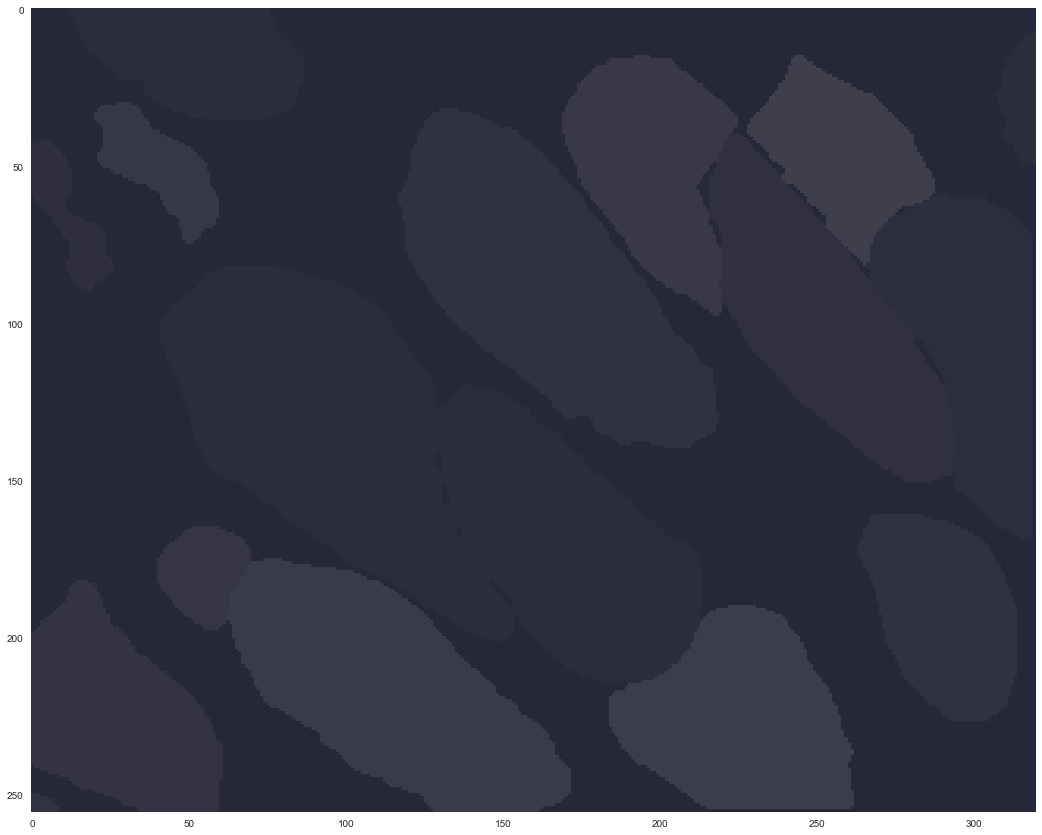

In [25]:
big_nuclei = df_mask.index[df_mask['img_index'] == biggest_mask_img_index]
plt.figure(figsize=(18, 18))
for i, mask_id in enumerate(big_nuclei):
    plt.grid(None)
    plt.imshow(masks[mask_id], interpolation='none', alpha=0.1)

Whereas the nuclei in the image overlap the masks do not appear to do so. 

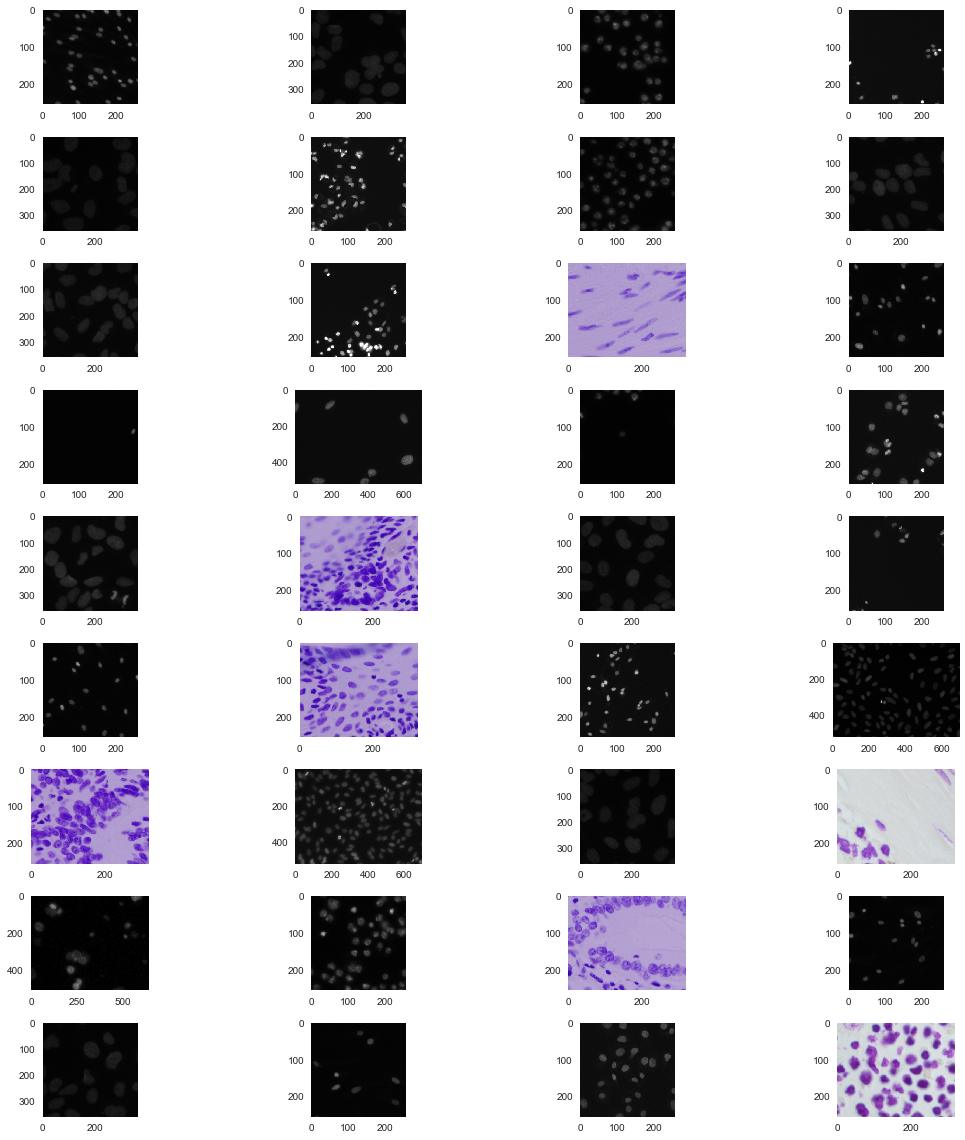

In [26]:
sample_nuclei = df_img.sample(36).index
fig, ax = plt.subplots(9, 4, figsize=(16, 16))
row = 0
col = 0
for i, img_id in enumerate(sample_nuclei):
    ax[col, row].grid(False)
    ax[col, row].imshow(imgs[img_id])
    
    # Update the row and col indices
    row = row + 1
    if(row == 4):
        row = 0
    if((i + 1) % 4 == 0):
        col = col + 1
plt.tight_layout()

There is a wide range of different nuclei sizes and shapes.

**Conclusion**

There is a large range of image dimensions in the dataset and not all of the images are square. The smallest image was 256x256 and the largest was 1040x1388 pixels. The smallest nucleus was only a few pixels in size and was found in one of the larger images (1000x1000), resizing this image caused the tiny nucleus to disappear so resizing images should be approached with great caution. The size of nuclei vary a lot throughout the images in the training set and is likely to make detection more challenging. 

I have only scratched the surface of this dataset and there is much more to explore. A few more things I would like to look into are the distribution of color in the images, identifying different nuclei groups/clusters and taking a look at the test set.

*Any suggestions for improvements would be very helpful. Also, please don't hesitate to point out any mistakes I might have made (there are probably a lot of them!).*

I adapted various parts of the following kernels while putting this together:
- https://www.kaggle.com/jerrythomas/exploratory-analysis
- https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277